# MSE403 Lab 5: Linear Regression
This lab is to perform linear regression and thresholding on three ternary systems that make of 3/4 of a Co-Zr-Cr-Ti quaternary metallic glass forming alloy, and build a model to predict the formation of metallic glass in the entire quaternary system.

#### Reference and Github copilot usage
The entire coding section of this lab report is written under the help of Github Copilot. The usage of large language model like chatGPT will be marked.
A large section of code in this report is modified from MSE403 Practice 5. Any external reference will be marked.

## 1. Open the data, perform basic data preparation/cleaning

import the necessary packages, and read the data of each ternary system, contatenating them into a quaternary dataframe.

In [1]:
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy

In [2]:
df_crtizr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CrTiZr')   #read the data of each ternary system
df_crtizr = df_crtizr.dropna(axis=1)
df_crtizr['Co'] = 0   #For Co which does not exist in this ternary system, its composition would be set to 0

df_crcozr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CrCoZr')
df_crcozr = df_crcozr.dropna(axis=1)
df_crcozr['Ti'] = 0

df_cotizr = pd.read_excel('Metallic Glass Data.xlsx', sheet_name='CoTiZr')
df_cotizr = df_cotizr.dropna(axis=1)
df_cotizr['Cr'] = 0

df_qua = pd.concat([df_crtizr, df_crcozr, df_cotizr], ignore_index=True)
df_qua = df_qua[['Cr', 'Co', 'Ti', 'Zr', 'MaxFWHM']]
df_qua_nopoly = df_qua.copy()   #save the original dataframe for later use

Define some useful functions

In [5]:
def drop_correlated_features(df, threshold):
    '''
    Define a function that drops features that are highly correlated with each other
    The threshold is the correlation value above which a feature is considered highly correlated.
    Return a list of the columns names that should be dropped
    '''
    #Generated by ChatGPT
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

def add_polynomical_features(df,degree):
    '''
    Define a function that adds polynomial features to the dataframe
    For each feature in the dataframe, adding n-1 features that are the power of 2 to n of the original feature
    (n is the number of degrees)
    '''
    for column in df.columns:
        if column in ['Cr', 'Co', 'Ti', 'Zr']:
                for i in range(2,degree+1):
                    df[column+'^'+str(i)] = df[column]**i
    return df

## 2. Demonstrate your ability to perform linear regression using composition (or polynomial combinations of composition) to build a model that predicts the MaxFWHM for the entire quaternary phase diagram.


#### a. Test your model’s generalizability by performing Cross Validation studies

i. **Perform LOCO-CV by splitting the dataset by ternary systems**

C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.one

The average mean squared error is:  40.886
The average R^2 score is:  -3054.568


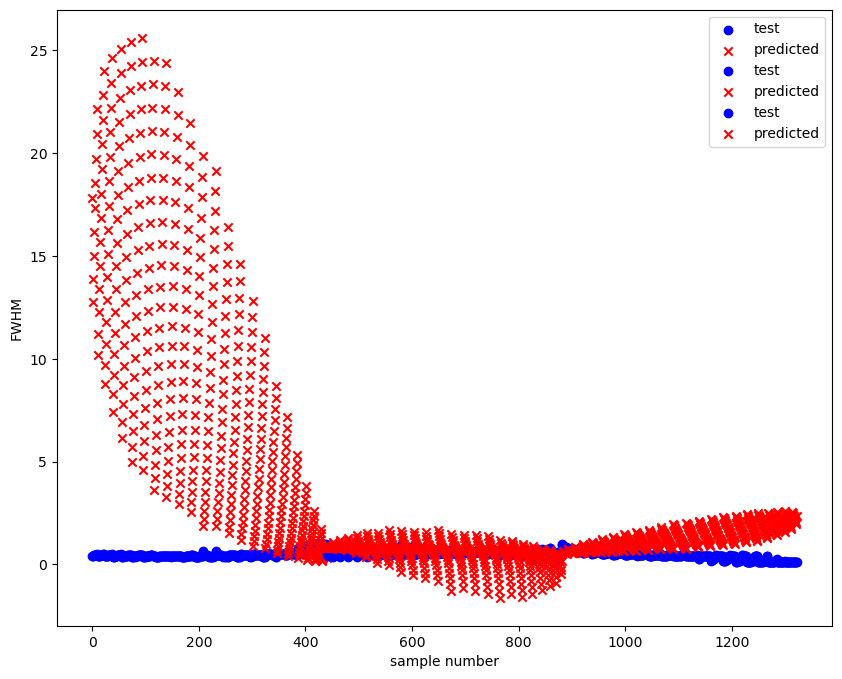

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def LOCO_CV(df_qua, threshold = 1, add_polynomial = False, degree=3 ,plot = True):
    '''
    Define a function that performs LOCO-CV by splitting the dataset by ternary systems. The data would be standardized within this function. Correlation analysis can be performed within this function and the highly correlated features can be dropped, the threshold can be set in the input parameter. Polynomial features can be added to the dataset to optimize the linear regression model, the degree can be set in the input parameter.
    '''

    group = np.zeros(len(df_qua))
    for i in range(len(df_qua)):   #seperate each ternary system into three different groups
        if df_qua['Cr'][i] == 0:
            group[i] = 0
        elif df_qua['Co'][i] == 0:
            group[i] = 1
        elif df_qua['Ti'][i] == 0:
            group[i] = 2
    df_qua['group'] = group
    mse = []
    r2 = []

    for i in range(3):   #for each ternary system, the system would be used as the test set, and the other two systems would be used as the training set to perform LOCO-CV

        qua_test_y = df_qua[df_qua['group'] == i]['MaxFWHM']   #the FWHM value of the test set
        qua_test_x = df_qua[df_qua['group'] == i].loc[:, ~df_qua.columns.isin(['MaxFWHM', 'group'])]   #the composition features of the test set
        qua_train_y = df_qua[df_qua['group'] != i]['MaxFWHM']   #the FWHM value of the training set
        qua_train_x = df_qua[df_qua['group'] != i].loc[:, ~df_qua.columns.isin(['MaxFWHM', 'group'])]   #the composition features of the training set

        to_drop = drop_correlated_features(qua_train_x, threshold = threshold)   #correlation analysis
        qua_train_x = qua_train_x.drop(to_drop, axis=1)
        qua_test_x = qua_test_x.drop(to_drop, axis=1)   #drop the highly correlated features

        if add_polynomial:   #add polynomial features. The add_polynomial is set to be True by default
            qua_train_x = add_polynomical_features(qua_train_x, degree=degree)   #add polynomial features to three degrees
            qua_test_x = add_polynomical_features(qua_test_x, degree=degree)

        #In each iteration, standardize the x data based on fitting of the training set
        scaler = StandardScaler()
        scaler.fit(qua_train_x)

        qua_train_x, qua_test_x = scaler.transform(qua_train_x), scaler.transform(qua_test_x)

        #Linear Regression
        LR = LinearRegression()
        LR.fit(qua_train_x, qua_train_y)
        qua_test_y_pred = LR.predict(qua_test_x)
        mse.append(mean_squared_error(qua_test_y, qua_test_y_pred))   #calculate the MSE and R2 score of each iteration
        r2.append(r2_score(qua_test_y, qua_test_y_pred))

        if plot:   #Create a plot to compare the predicted FWHM and the actual FWHM value
            plt.figure(1,figsize=(10,8))
            plt.scatter(np.arange(i*441,i*441+441,1),qua_test_y, label='test',c = 'b')
            plt.scatter(np.arange(i*441,i*441+441,1), qua_test_y_pred, marker='x', c='r', label='predicted')
            #plt.legend(loc='best')
            plt.xlabel('sample number')
            plt.ylabel('FWHM')

    plt.legend()

    print('The average mean squared error is: ', round(np.mean(mse),3))
    print('The average R^2 score is: ', round(np.mean(r2),3))

LOCO_CV(df_qua, add_polynomial = True, degree=3)   #Perform LOCO_CV, the polynomial features are added to degree of 3



It can be seen from the plot and the R2 score that the predictions are entirely off. This aligns with the nature of LOCO-CV, because the model trained by two ternary systems cannot predict the thrid ternary system.

**ii. Perform random CV**

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

def random_cv(df_qua, add_polynomial = True, degree=3, threshold = 0.9):   #Define a function to perform random CV
    '''
    Perform random cross validation on the dataset
    '''
    df_qua = df_qua.sample(frac=1)  #shuffle the dataframe to make sure the CV is random
    Y = df_qua['MaxFWHM'][:,None]
    X = df_qua.loc[:, ~df_qua.columns.isin(['MaxFWHM', 'group'])]
    X = X.drop(drop_correlated_features(X, threshold), axis=1)   #drop features that are highly correlated
    if add_polynomial:
        X = add_polynomical_features(X, degree)   #add polynomial features

    LR = LinearRegression(fit_intercept=True)
    scalar = StandardScaler()

    pipeline = Pipeline([('transformer', scalar), ('estimator', LR)])   #Create a pipeline to standardize the data within each CV fold

    print('The average 5 fold cv score is', round(cross_val_score(pipeline, X, Y, cv=5).mean(),4))

random_cv(df_qua)




The average 5 fold cv score is 0.6714


C:\Users\28452\AppData\Local\Temp\ipykernel_18536\582012609.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = df_qua['MaxFWHM'][:,None]
C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


*The Pipeline function is borrowed from:
https://stackoverflow.com/questions/44446501/how-to-standardize-data-with-sklearns-cross-val-score*

The R2 score of the random CV is around 0.65-0.7 (it can vary each time since the data is shuffled) with polynomial features of the composition added, which is quite decent.


Note that for each CV, standardization is fit to the training set and transform both the training and validation set to prevent information leakage.

#### b. Report your training and validation errors
**i. Provide a parity plot for each with the R2 clearly marked.**

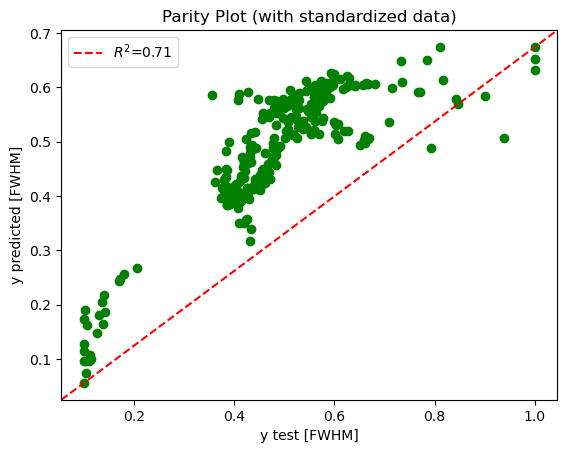

In [8]:
def parity_plot(df):
    '''
    Perform test train split and plot the parity plot with R2 score marked
    '''
    Y = df['MaxFWHM']
    X = df.loc[:, ~df.columns.isin(['MaxFWHM', 'group'])]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)   #perform test train split
    scalar = StandardScaler()   #Standardization
    scalar.fit(X_train)
    X_train, X_test = scalar.transform(X_train), scalar.transform(X_test)
    LR = LinearRegression(fit_intercept=True)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)   #Get the predicted FWHM values from the model

    #plot parity plot
    plt.scatter(y_test, y_pred, c='g')
    plt.xlabel('y test [FWHM]')
    plt.ylabel('y predicted [FWHM]')
    plt.title('Parity Plot (with standardized data)')
    #plot a line y=x all along the parity plot to compare with ideal correct result- copilot
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='r', label='$R^{2}$='+ str(round(r2_score(y_test, y_pred),3)))
    plt.legend()

df_qua_poly = add_polynomical_features(df_qua, degree=3)
parity_plot(df_qua_poly)   #Parity plot of random CV




#### c. Train a full data composition model

array([0.57071346, 0.58463452, 0.57895121, ..., 0.68137303, 0.6784951 ,
       0.70827476])

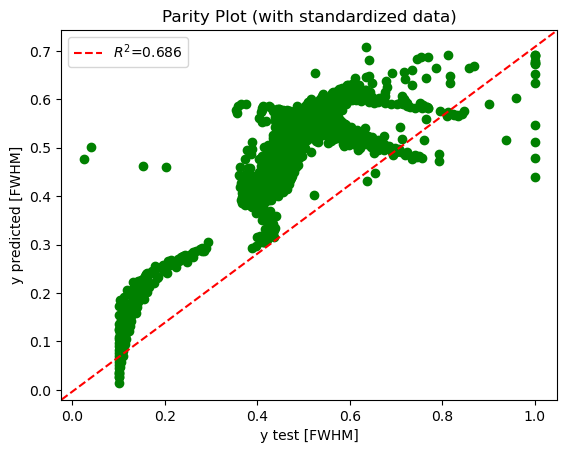

In [9]:
def train_full_data(df_qua, parity = True):
    '''
    Define a funciton that would train the model with the full dataset and generate a parity plot of the random CV.
    The function returns the predicted y vlaue (FWHM) of the entire dataset
    '''

    Y = df_qua['MaxFWHM']
    X = df_qua.loc[:, ~df_qua.columns.isin(['MaxFWHM', 'group'])]

    scalar = StandardScaler()   #Stardardization
    scalar.fit(X)
    X = scalar.transform(X)

    LR = LinearRegression(fit_intercept=True)
    LR.fit(X, Y)   #Train the model with the full dataset
    y_pred = LR.predict(X)

    if parity:   #Parity plot of the full dataset
        plt.scatter(Y, y_pred, c='g')
        plt.xlabel('y test [FWHM]')
        plt.ylabel('y predicted [FWHM]')
        plt.title('Parity Plot (with standardized data)')
        #plot a line y=x all along the parity plot - copilot
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='r', label='$R^{2}$='+ str(round(r2_score(Y, y_pred),3)))
        plt.legend()

    return y_pred

train_full_data(df_qua)


Surprisingly, despite the fact that information leakage happens, the model still performs the same as previous models without overestimation. The reason for it is yet to be found.

## 3. Demonstrate your ability to perform linear regression using matminer features to build a model that predicts the MaxFWHM for the entire quaternary phase diagram.

#### a. Explore the broader set of features available via matminer

In [10]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema

formula = 'Cr'+df_qua['Cr'].astype(str)+'Ti'+df_qua['Ti'].astype(str)+'Co'+df_qua['Co'].astype(str)+'Zr'+df_qua['Zr'].astype(str)
df_mat = pd.DataFrame({'Formula':formula, 'MaxFWHM':df_qua['MaxFWHM']})

#convert the formula from a string into chemical composition
df_mat = StrToComposition().featurize_dataframe(df_mat, "Formula")   #Featurization
df_mat = Miedema().featurize_dataframe(df_mat, col_id="composition")   #Featurization using Miedema featurizer


StrToComposition:   0%|          | 0/1323 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1323 [00:00<?, ?it/s]

In [11]:
from matminer.featurizers.composition import WenAlloys

df_mat = WenAlloys().featurize_dataframe(df_mat, col_id="composition")   #Featurization using WenAlloys featurizer


WenAlloys:   0%|          | 0/1323 [00:00<?, ?it/s]

The features that are not numerical (not helpful for training the model) are dropped.

In [12]:
#drop the columns if they exist
df_mat=df_mat.drop(['Weight Fraction','Atomic Fraction','composition','Formula'],axis=1,errors='ignore')

#### b. Test your model’s generalizability by performing Cross Validation studies

**i. Perform LOCO-CV by splitting the dataset by ternary systems.**

C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.one

The average mean squared error is:  0.397
The average R^2 score is:  -39.323


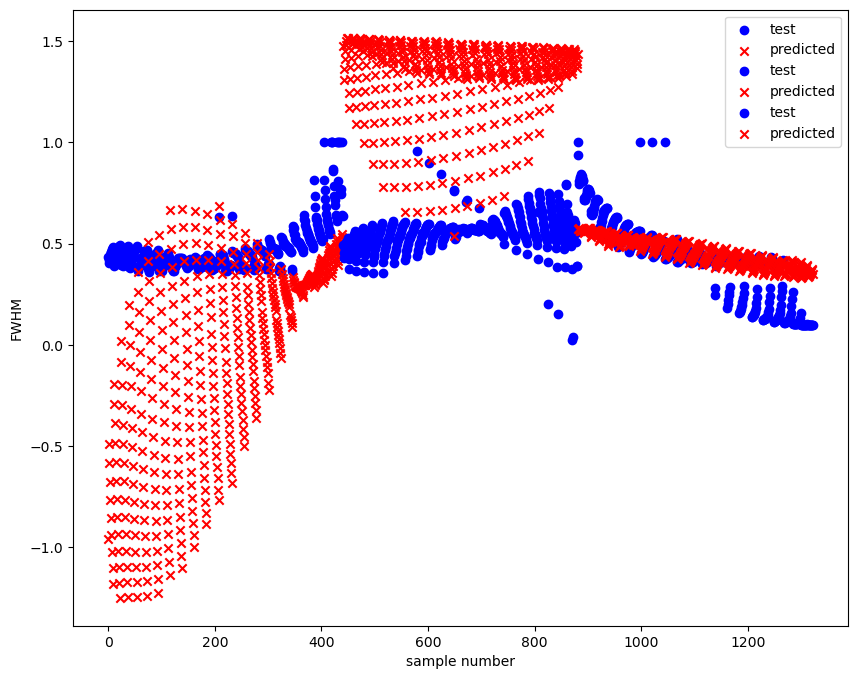

In [59]:
df_mat['Cr'] = df_qua['Cr']   #add the composition feature to the featurized dataframe
df_mat['Ti'] = df_qua['Ti']
df_mat['Co'] = df_qua['Co']
df_mat['Zr'] = df_qua['Zr']
df_mat_nopoly = df_mat.copy()   #Save the dataframe without polynomial features for later use

LOCO_CV(df_mat, threshold=0.9, add_polynomial = True, degree=3)


same as the previous model, the LOCO-CV performs poorly.

**ii. Perform random CV**

In [61]:
random_cv(df_mat, threshold=0.9)   #Perform random CV with the featurized dataset with different threshold for correlation analysis
random_cv(df_mat, threshold=0.95)
random_cv(df_mat, threshold=0.85)

The average 5 fold cv score is 0.7599
The average 5 fold cv score is 0.8342
The average 5 fold cv score is 0.6502


C:\Users\28452\AppData\Local\Temp\ipykernel_18536\582012609.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = df_qua['MaxFWHM'][:,None]
C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\28452\AppData\Local\Temp\ipykernel_18536\582012609.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  

Note that the threshold for dropping correlated features significantly influence the predictive power of the model. THe higher the threshold, the less features dropped, the high the predictive power. However, if the threshold is set to be too high, the highly correlated features in the model will lead to overfitting and poor generalizability. Therefore, the bias-variance tradeoff should be considered when choosing the threshold.

#### c. Report your training and validation errors
**i. Provide a parity plot for each with the R2 clearly marked.**

C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


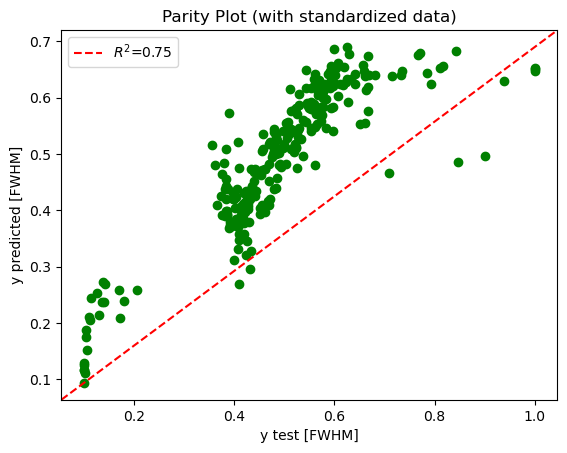

In [63]:
df_mat_poly = add_polynomical_features(df_mat, degree=3)  #add polynomial features
df_mat_poly = df_mat_poly.drop(drop_correlated_features(df_mat_poly, threshold=0.9), axis=1)  #threshold is set to be 0.9 for now
parity_plot(df_mat_poly)

with polynomial features added and threshold set to be 0.9, the R2 score is around 0.75

#### d. Train a full data composition model

array([0.44300748, 0.42473421, 0.42327891, ..., 0.64981888, 0.64839133,
       0.65933748])

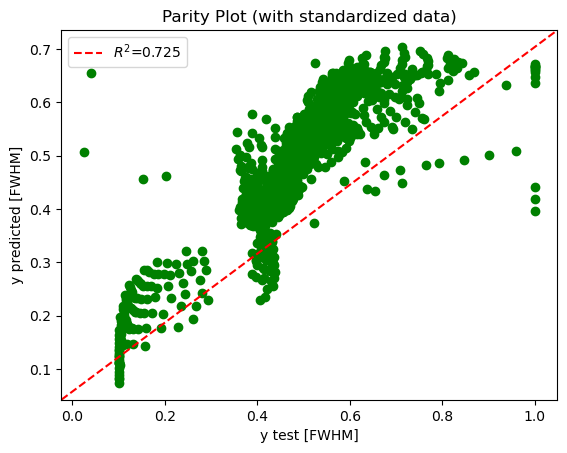

In [64]:
train_full_data(df_mat_poly)

## 4. Predict the FWHM for the entire Co-Zr-Cr-Ti quaternary phase diagram (use 5 at.% increments) using both your composition and matminer full data models

#### a. Plot the results of both your models in the Yang plots we have talked about in class several times – color the points by the value of MaxFWHM

In [17]:
dict_entire_qua = {'Cr':[], 'Ti':[], 'Co':[], 'Zr':[]}  #copilot

for cr in np.arange(0,1.05,0.05):   #Creat the quaternary composition dataframe with 5 at.% increments
    for ti in np.arange(0,1.05,0.05):
        for co in np.arange(0,1.05,0.05):
            for zr in np.arange(0,1.05,0.05):
                if cr+ti+co+zr == 1.0:
                    dict_entire_qua['Cr'].append(round(cr,3))
                    dict_entire_qua['Ti'].append(round(ti,3))
                    dict_entire_qua['Co'].append(round(co,3))
                    dict_entire_qua['Zr'].append(round(zr,3))
df_entire_qua = pd.DataFrame(dict_entire_qua)
df_entire_qua_nopoly = df_entire_qua.copy()
df_entire_qua_poly = add_polynomical_features(df_entire_qua, degree=3)   #save the dataframe with and without polynomial features



Featurize the entire quaternary dataset with previously used MatMiner featurizers.

In [18]:
formula = 'Cr'+df_entire_qua['Cr'].astype(str)+'Ti'+df_entire_qua['Ti'].astype(str)+'Co'+df_entire_qua['Co'].astype(str)+'Zr'+df_entire_qua['Zr'].astype(str)
df_entire_mat = pd.DataFrame({'Formula':formula})

#convert the formula from a string into chemical composition
df_entire_mat = StrToComposition().featurize_dataframe(df_entire_mat, "Formula")
df_entire_mat = Miedema().featurize_dataframe(df_entire_mat, col_id="composition")
df_entire_mat = WenAlloys().featurize_dataframe(df_entire_mat, col_id="composition")

                  Formula
0    Cr0.0Ti0.0Co0.0Zr1.0
1  Cr0.0Ti0.0Co0.05Zr0.95
2    Cr0.0Ti0.0Co0.1Zr0.9
3  Cr0.0Ti0.0Co0.15Zr0.85
4    Cr0.0Ti0.0Co0.2Zr0.8


StrToComposition:   0%|          | 0/1584 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1584 [00:00<?, ?it/s]

WenAlloys:   0%|          | 0/1584 [00:00<?, ?it/s]

The Yang Omega values from MatMiner skyrockets when the alloy has only Titanium and Zirconium.

In [67]:
def train_model_and_predict(df_mod, df, threshold=0.9):
    '''
    Train the model with the full dataset and predict the FWHM for the entire quaternary dataset.
    df_mod: the training dataset
    df: the entire quaternary dataset
    threshold: the threshold for dropping correlated features
    The function returns the predicted FWHM values for the entire quaternary dataset
    '''

    Y_mod = df_mod['MaxFWHM']
    X_mod = df_mod.loc[:, ~df_mod.columns.isin(['MaxFWHM', 'group'])]
    to_drop = drop_correlated_features(X_mod, threshold=threshold)
    X_mod = X_mod.drop(to_drop, axis=1)

    LR = LinearRegression(fit_intercept=True)
    LR.fit(X_mod, Y_mod)   #Train the model with the full dataset

    X = df.loc[:, ~df.columns.isin(['MaxFWHM', 'group'])]
    X = X.drop(to_drop, axis=1)

    Y_pred = LR.predict(X)


    return Y_pred

C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
C:\Users\28452\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\28452\AppData\Local\Temp\ipykernel_18536\1250620686.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by it

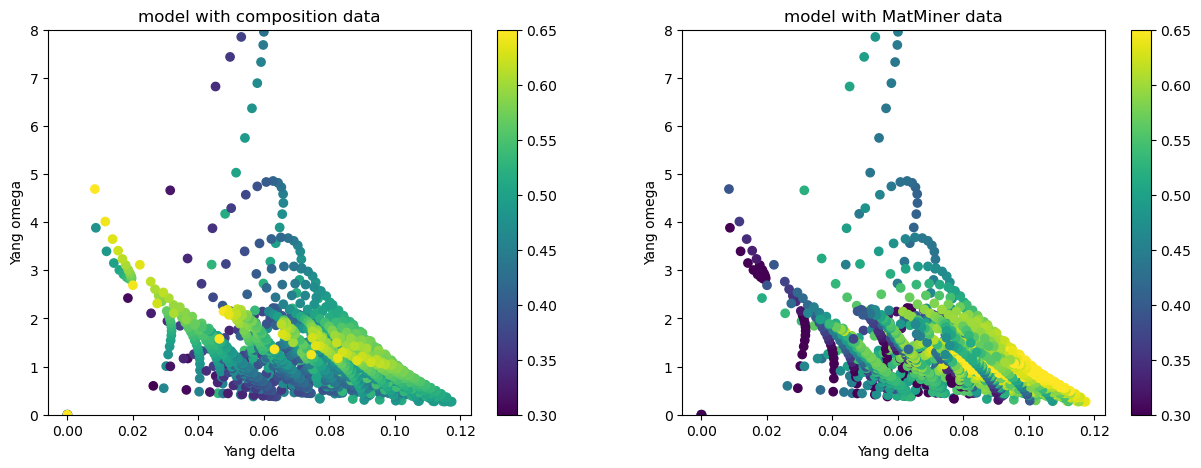

In [71]:
df_mat_poly = add_polynomical_features(df_mat, degree=3)
df_entire_mat_poly = pd.concat([df_entire_mat, df_entire_qua_poly], axis=1)   #add composition features
df_entire_mat_nopoly = pd.concat([df_entire_mat, df_entire_qua_nopoly], axis=1)   #add composition features
Yang_delta_nodrop = df_entire_mat_nopoly['Yang delta']   #save the Yang delta and omega values for the entire quaternary dataset
Yang_omega_nodrop = df_entire_mat_nopoly['Yang omega']

Yang_delta = df_entire_mat_nopoly['Yang delta']
Yang_omega = df_entire_mat_nopoly['Yang omega']

df_entire_mat_nopoly=df_entire_mat_nopoly.drop(['Weight Fraction', 'Atomic Fraction', 'composition', 'Formula'], axis=1, errors='ignore')   #Drop unnecessary columns
df_entire_mat_poly=df_entire_mat_poly.drop(['Weight Fraction', 'Atomic Fraction', 'composition', 'Formula'], axis=1, errors='ignore')

qua_Y_pred = train_model_and_predict(df_qua_poly, df_entire_qua_poly, threshold=0.85)   #Train the model with composition data and predict the FWHM for the entire quaternary dataset
mat_Y_pred = train_model_and_predict(df_mat_poly, df_entire_mat_poly, threshold=0.85)   #Train the model with MatMiner data and predict the FWHM for the entire quaternary dataset
#The threshold is finally determined to be 0.85 after several trials. It is a reasonable threshold to prevent overfitting while keeping a relatively high predictive power.

plt.figure(2,(15,5))
ax1 = plt.subplot(121)
plt.scatter(Yang_delta_nodrop, Yang_omega_nodrop, c = qua_Y_pred)  #Yang's plot for the first model
#add y limit
plt.ylim(0, 8)
#add c limit
plt.clim(0.3,0.65)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.title('model with composition data')
plt.colorbar()

ax2 = plt.subplot(122)
plt.scatter(Yang_delta, Yang_omega, c = mat_Y_pred)   #Yang's plot for the second model
plt.ylim(0, 8)
plt.clim(0.3,0.65)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.title('model with MatMiner data')
plt.colorbar()

#### b. Determine a threshold MaxFWHM and color the data points by whether or not the alloy is likely to form a glass or not.

Text(0.5, 1.0, 'model with MatMiner data')

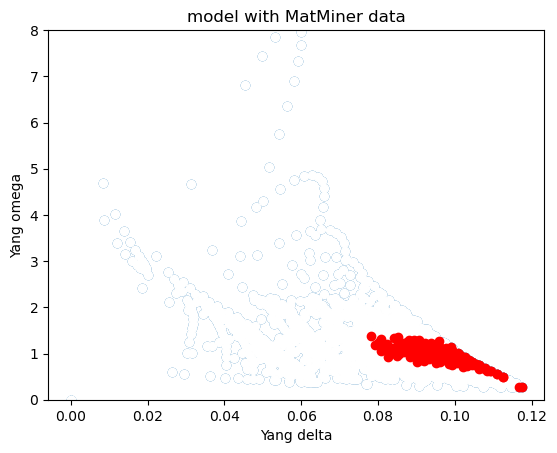

In [70]:
plt.scatter(Yang_delta, Yang_omega)

plt.scatter(Yang_delta[mat_Y_pred <= 0.65], Yang_omega[mat_Y_pred <= 0.65], c = 'w')   #The threshold is set to be 0.65 based on the plot above
plt.scatter(Yang_delta[mat_Y_pred > 0.65], Yang_omega[mat_Y_pred > 0.65], c = 'r')   #The metallic glass forming alloys are colored in red
plt.ylim(0, 8)
plt.clim(0.3,0.65)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.title('model with MatMiner data')

The metallic glass is likely to form when the Yang delta is high and the Yang omega is low.

#### c. Create a graph comparing the location of your training data versus your predictions

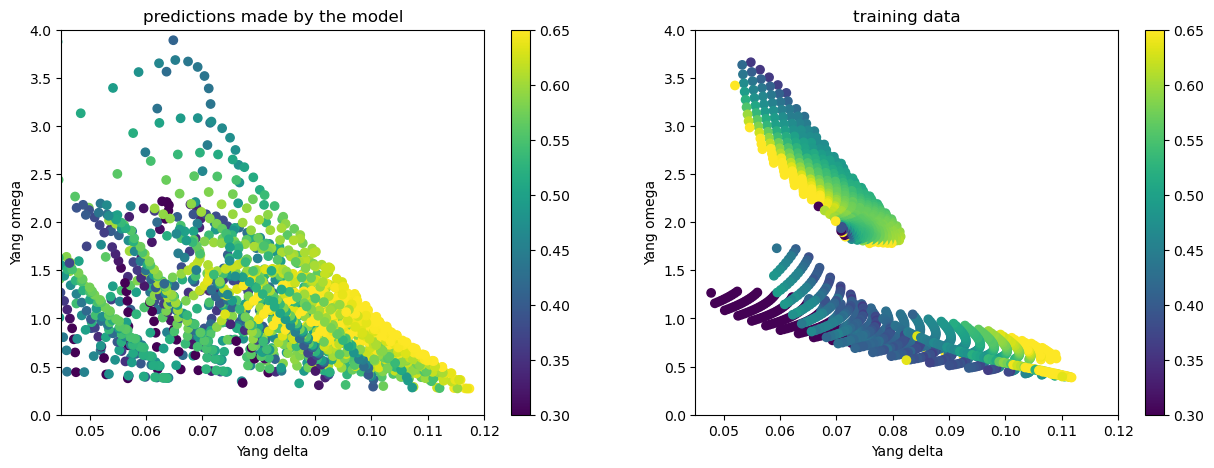

In [69]:
Yang_omega_train = df_mat_poly['Yang omega']
Yang_delta_train = df_mat_poly['Yang delta']

plt.figure(2,(15,5))
ax1 = plt.subplot(121)
plt.scatter(Yang_delta_nodrop, Yang_omega_nodrop, c = mat_Y_pred)
#add y limit
plt.ylim(0, 4)
plt.xlim(0.045,0.12)
#add c limit
plt.clim(0.3,0.65)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.title('predictions made by the model')
plt.colorbar()

#plt.show()

ax2 = plt.subplot(122)
plt.scatter(Yang_delta_train, Yang_omega_train, c = df_mat_poly['MaxFWHM'])
plt.ylim(0, 4)
plt.xlim(0.045,0.12)
plt.clim(0.3,0.65)
plt.xlabel('Yang delta')
plt.ylabel('Yang omega')
plt.title('training data')
plt.colorbar()

It can be seen from the comparison that the model is able to predict the FWHM values for the entire quaternary dataset with a reasonable accuracy, compared to the training data. Note that information leakage can be a factor that influence the predictive power of the model.

## Summary

- The model with MatMiner features performs much better than the model only with composition features. Reasonable predictions are made for the entire quaternary dataset, with the featurized model.
- The predictions of the model makes physical sense, with the majority of the predictions of the FWHM values being in the range of 0.3-0.65. If the FWHM value does not make sense, it is likely that the model is overfitting (which was resolved by dropping more correlated features).
- Since thermodynamics properties play important roles on glass formations, the model can be further improved with adding thermodynamic features such as melting temperature, enthalpy of formation, etc.
- The LOCO-CV result has extremely low R2 score, while the random CV result has a relatively high R2 score. This is likely due to the fact that the LOCO-CV result is more biased, and the random CV can reflect the actual model predictive power.
- The prediction of glass versus not-glass is sensitive to the MaxFWHM threshold. The threshold is determined to be 0.65 based on the predictions made, but more accurate threshold can be determined from literature.